In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import time

import pathlib
import json
import numpy as np
import time
import matplotlib.pyplot as plt


In [112]:
def load_head_data(experiments_path):
    head_data = {}
    for task_dir in experiments_path.iterdir():
        head_data[task_dir.stem] = {}
        for seed_dir in task_dir.iterdir():
            head_mask = np.load(seed_dir / "head_mask.npy")
            head_importance = np.load(seed_dir / "head_importance.npy")
            head_data[task_dir.stem][seed_dir.stem] = {
                "head_mask": head_mask,
                "importance": head_importance
            }
    return head_data
def load_mlp_data(experiments_path):
    mlp_data = {}
    for task_dir in experiments_path.iterdir():
        mlp_data[task_dir.stem] = {}
        for seed_dir in task_dir.iterdir():
            mlp_mask = np.load(seed_dir / "mlp_mask.npy")
            mlp_importance = np.load(seed_dir / "mlp_importance.npy")
            mlp_data[task_dir.stem][seed_dir.stem] = {
                "mlp_mask": mlp_mask,
                "importance": mlp_importance
            }
    return mlp_data
def plot_all_task_metrics(metrics, title):
    for name in metrics[0][1].keys():
        plot_task_metrics(analyzed_metrics, name, title)


def plot_matrix(mean_matrix, stddv_matrix, x_labels, y_labels, save_path, x_title='', y_title='', colour_map=plt.cm.OrRd):
    fig, ax = plt.subplots(figsize=(9,8))
    ax.set_xlabel(x_title, labelpad=20)
    ax.set_ylabel(y_title)
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    ax.set_xticks(range(len(x_labels)))
    ax.set_yticks(range(len(y_labels)))
    ax.set_xticklabels(x_labels)
    ax.set_yticklabels(y_labels)
    ax.imshow(mean_matrix, cmap=colour_map)
    plt.tight_layout()
    for i in range(len(mean_matrix)):
        for j in range(len(mean_matrix[0])):
            mean = mean_matrix[i, j]
            std =  stddv_matrix[i, j]
            ax.text(j, i, f"{mean:.2f}\n{std:.2f}", va='center', ha='center')
    if save_path:
        fig.savefig(save_path, bbox_inches='tight')
    plt.show()

def show_heads_heatmap(head_data, save_name):
    tasks = sorted(list(head_data.keys()))
    seeds = head_data[tasks[0]].keys()
    
    pruned_head_results = np.zeros((len(seeds), 12, 12)) # 12 layers with 12 heads each
    for task_idx, task in enumerate(tasks):
        for seed_idx, seed in enumerate(seeds):
            
            head_mask = head_data[task][seed]["head_mask"]
            importance = head_data[task][seed]["importance"]
            flat = head_mask.reshape(-1)
            ind = np.argpartition(head_mask*importance,-10, axis=None)[:-10]
            flat[ind] = 0
            
            pruned_head_results[seed_idx] += flat.reshape(head_mask.shape)
            
            
    mean_pruned_heads = np.mean(pruned_head_results, axis=0)
    std_pruned_heads = np.std(pruned_head_results, axis=0, ddof=1)
    plot_matrix(mean_pruned_heads, std_pruned_heads, list(map(str, range(12))), list(map(str, range(12))), save_name, "Head", "Layer")
    print("mean_survival_mean", mean_pruned_heads.mean())
    print("mean_survival_std", std_pruned_heads.mean())
    print("stable heads", (mean_pruned_heads > 5).sum())

def show_mlps_heatmap(mlp_data, save_name):
    tasks = sorted(list(mlp_data.keys()))
    seeds = mlp_data[tasks[0]].keys()
    
    pruned_mlps_results = np.zeros((len(seeds), 1, 12)) # 12 layers
    for task_idx, task in enumerate(tasks):
        for seed_idx, seed in enumerate(seeds):
            mlp_mask = mlp_data[task][seed]["mlp_mask"]
            importance = mlp_data[task][seed]["importance"]
            flat = mlp_mask.reshape(-1)
            ind = np.argpartition(mlp_mask * importance,-3, axis=None)[:-3]
            flat[ind] = 0
            pruned_mlps_results[seed_idx]  += flat.reshape(mlp_mask.shape)
    mean_pruned_mlps = np.mean(pruned_mlps_results, axis=0)
    std_pruned_mlps = np.std(pruned_mlps_results, axis=0, ddof=1)
    plot_matrix(mean_pruned_mlps, std_pruned_mlps, list(map(str, range(12))), [], save_name, "Layer", "")
    print("mean_survival_mean", mean_pruned_mlps.mean())
    print("mean_survival_std", std_pruned_mlps.mean())
    print("stable mlps", (mean_pruned_mlps > 5).sum())

    
def show_task_specific_heads_heatmap(head_data, directory, save_suffix):
    tasks = sorted(list(head_data.keys()))
    seeds = head_data[tasks[0]].keys()
    for task in tasks:
        print(task)
        pruned_head_results = np.zeros((len(seeds), 12, 12)) # 12 layers with 12 heads each
        for seed_idx, seed in enumerate(seeds):
            head_mask = head_data[task][seed]["head_mask"]
            importance = head_data[task][seed]["importance"]
            flat = head_mask.reshape(-1)
            ind = np.argpartition(head_mask*importance,-10, axis=None)[:-10]
            flat[ind] = 0
            pruned_head_results[seed_idx] += flat.reshape(head_mask.shape)
        mean_pruned_heads = np.mean(pruned_head_results, axis=0)
        std_pruned_heads = np.std(pruned_head_results, axis=0, ddof=1)
        
        save_path = None
        if directory is not None:
            save_path = f"{directory}/{task}_{save_suffix}"
            
        
        plot_matrix(mean_pruned_heads, std_pruned_heads, list(map(str, range(12))), list(map(str, range(12))), save_path, "Head", "Layer")
        print("mean_survival_mean", mean_pruned_heads.mean())
        print("mean_survival_std", std_pruned_heads.mean())
        print("stable heads", (mean_pruned_heads == 1.0).sum())

def show_task_specific_mlp_heatmap(mlp_data, directory, save_suffix):
    tasks = sorted(list(mlp_data.keys()))
    seeds = mlp_data[tasks[0]].keys()
    for task in tasks:
        print(task)
        pruned_mlps_results = np.zeros((len(seeds), 1, 12)) # 12 layers
        for seed_idx, seed in enumerate(seeds):
            mlp_mask = mlp_data[task][seed]["mlp_mask"]
            importance = mlp_data[task][seed]["importance"]
            
            flat = mlp_mask.reshape(-1)
            print("mask:", flat)
            print(np.argpartition(importance * mlp_mask,-3, axis=None)[-3:])
            ind = np.argpartition(importance * mlp_mask,-3, axis=None)[:-3]
            flat[ind] = 0
            print("flat", flat)
            pruned_mlps_results[seed_idx]  += flat.reshape(mlp_mask.shape)
        mean_pruned_mlps = np.mean(pruned_mlps_results, axis=0)
        std_pruned_mlps = np.std(pruned_mlps_results, axis=0, ddof=1)
        save_path = None
        if directory is not None:
            save_path = f"{directory}/{task}_{save_suffix}"

        plot_matrix(mean_pruned_mlps, std_pruned_mlps, list(map(str, range(12))), [], save_path, "Layer", "")
    
        print("mean_survival_mean", mean_pruned_mlps.mean())
        print("mean_survival_std", std_pruned_mlps.mean())
        print("stable mlps", (mean_pruned_mlps == 1.0).sum())



In [113]:

experiments_path = pathlib.Path("../masks/heads_mlps")
together_head_data = load_head_data(experiments_path)

experiments_path = pathlib.Path("../masks/heads_mlps")
together_mlp_data = load_mlp_data(experiments_path)


# Components heatmap

## Heads Heat map - Together

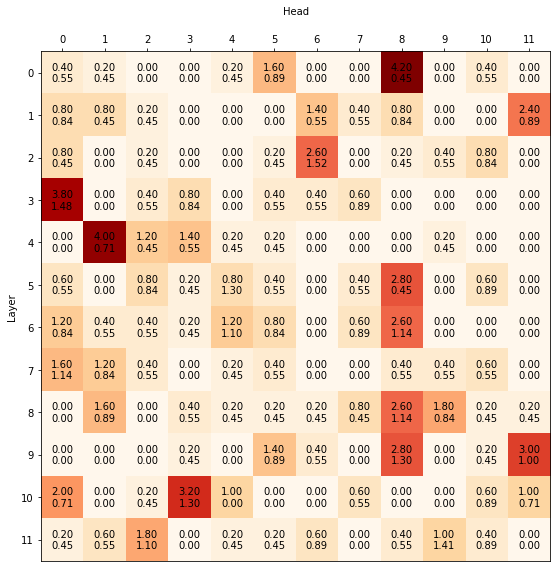

mean_survival_mean 0.5694444444444444
mean_survival_std 0.4142155169377115
stable heads 0


In [114]:
show_heads_heatmap(together_head_data, None)

## MLPs Heat map - Together setting

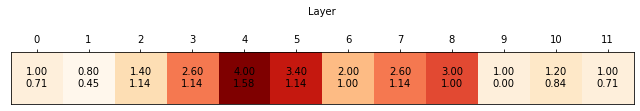

mean_survival_mean 2.0
mean_survival_std 0.9033273095739894
stable mlps 0


In [106]:
show_mlps_heatmap(together_mlp_data, None)

# Task Specific Heads Heat Map - Together setting

CoLA


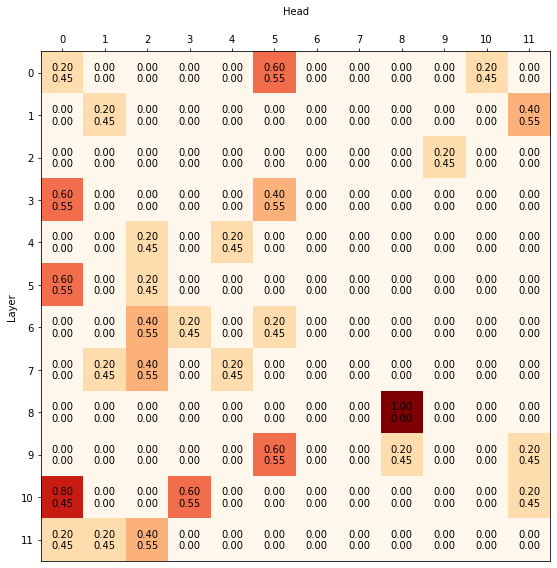

mean_survival_mean 0.06944444444444445
mean_survival_std 0.09083233818438158
stable heads 1
MNLI


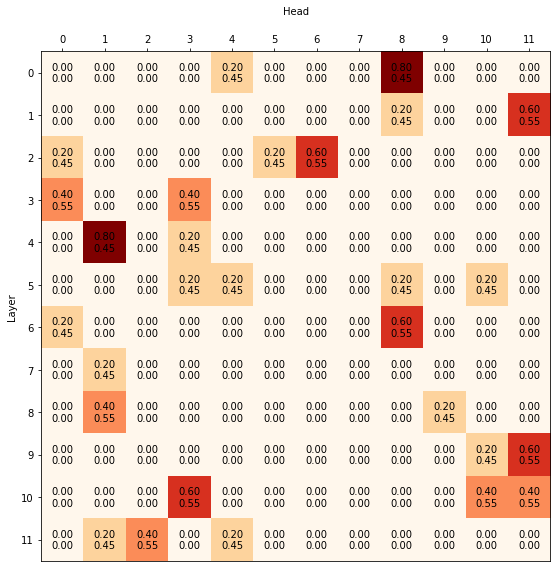

mean_survival_mean 0.06944444444444445
mean_survival_std 0.09463596705594525
stable heads 0
MRPC


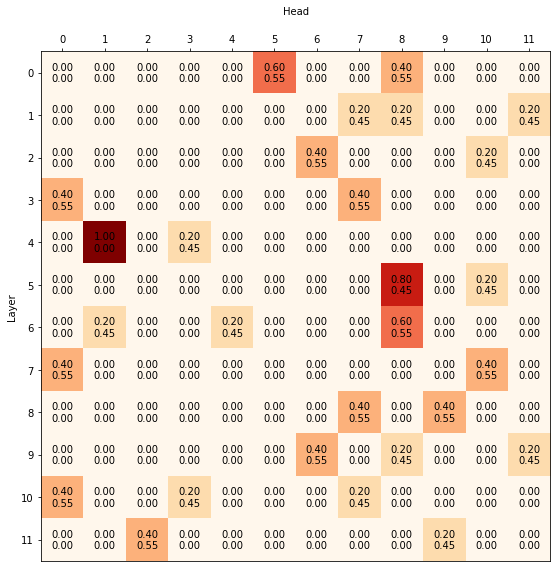

mean_survival_mean 0.06944444444444445
mean_survival_std 0.09292627489282342
stable heads 1
QNLI


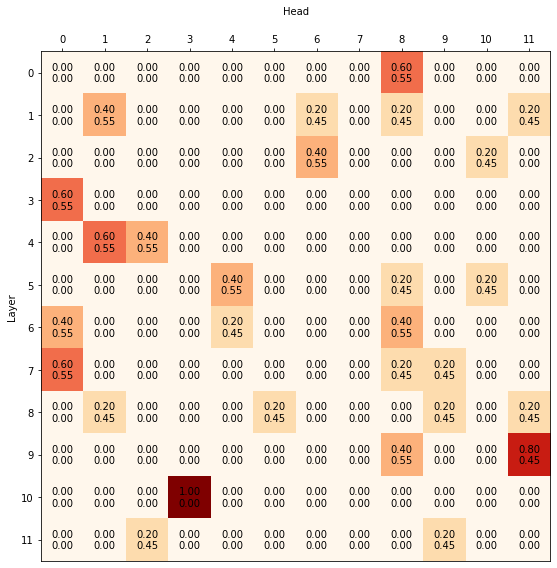

mean_survival_mean 0.06944444444444445
mean_survival_std 0.09153031708719553
stable heads 1
QQP


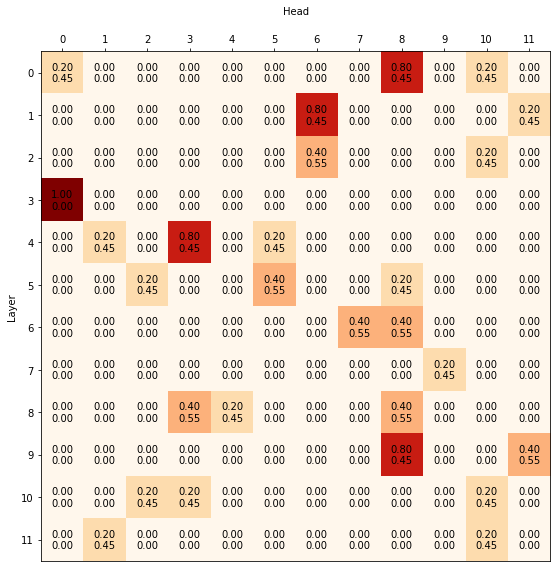

mean_survival_mean 0.06944444444444445
mean_survival_std 0.08563275150719003
stable heads 1
RTE


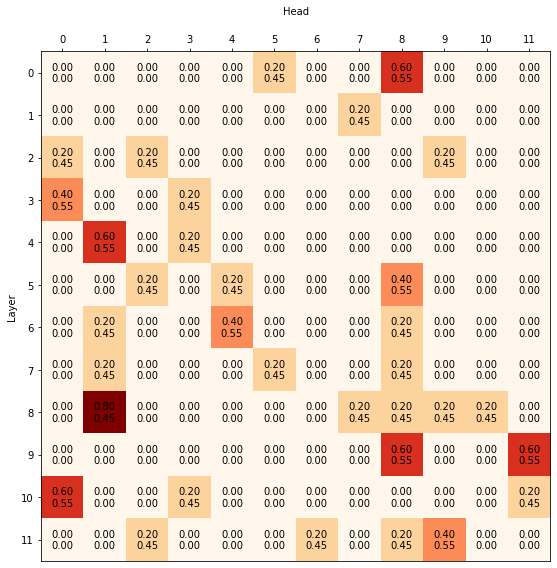

mean_survival_mean 0.06944444444444445
mean_survival_std 0.10876825909406589
stable heads 0
SST-2


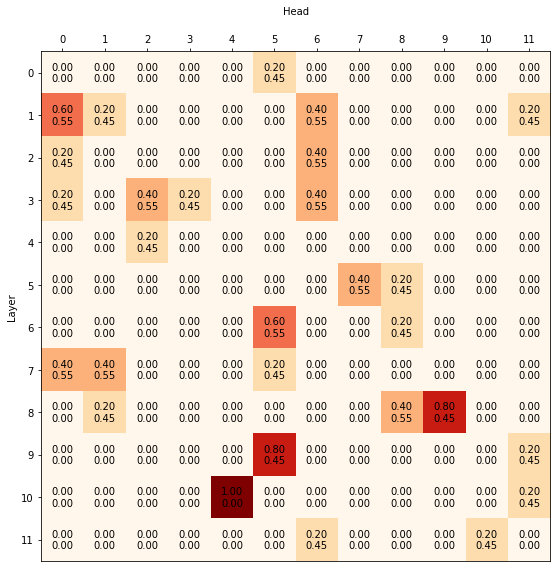

mean_survival_mean 0.06944444444444445
mean_survival_std 0.09083233818438158
stable heads 1
STS-B


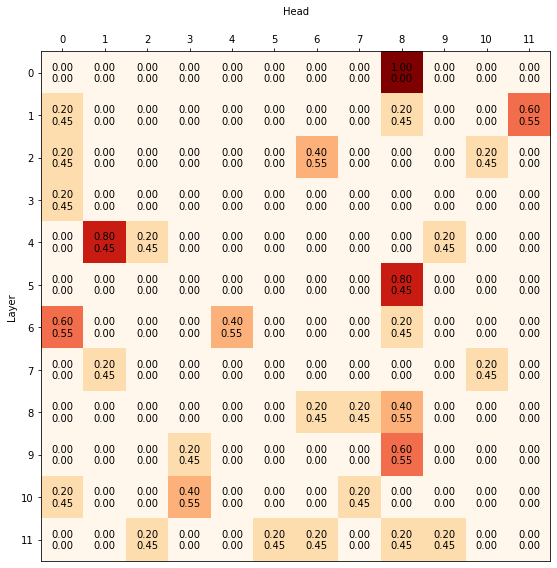

mean_survival_mean 0.06944444444444445
mean_survival_std 0.09494970141343917
stable heads 1
WNLI


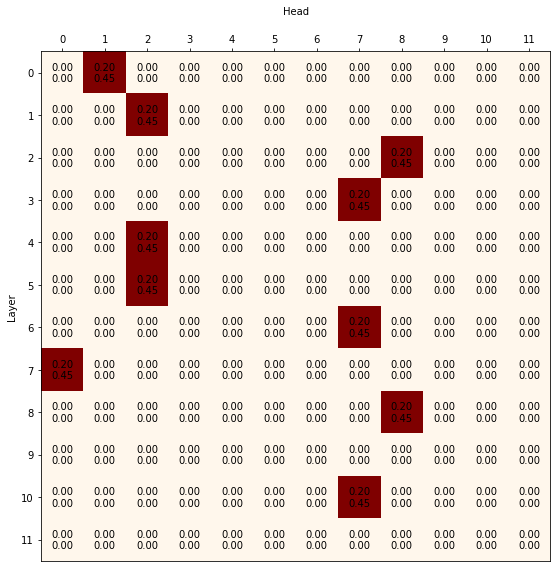

mean_survival_mean 0.013888888888888888
mean_survival_std 0.03105649968749709
stable heads 0


In [107]:
show_task_specific_heads_heatmap(together_head_data, None, None)

CoLA
mask: [1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[8 6 7]
flat [0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0.]
mask: [1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[5 4 3]
flat [0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
mask: [1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
[3 6 4]
flat [0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0.]
mask: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[8 7 6]
flat [0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0.]
mask: [1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.]
[8 6 7]
flat [0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0.]


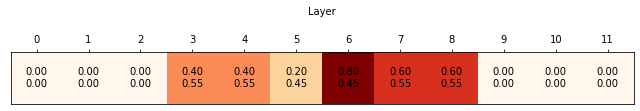

mean_survival_mean 0.25
mean_survival_std 0.2571097850850484
stable mlps 0
MNLI
mask: [1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0.]
[5 7 8]
flat [0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0.]
mask: [1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1.]
[ 4  7 10]
flat [0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.]
mask: [1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1.]
[8 4 7]
flat [0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0.]
mask: [1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0.]
[6 5 9]
flat [0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0.]
mask: [1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0.]
[5 8 0]
flat [1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.]


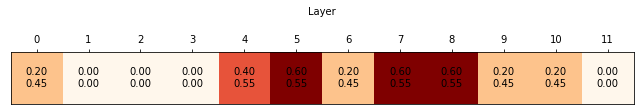

mean_survival_mean 0.25000000000000006
mean_survival_std 0.33164538433504137
stable mlps 0
MRPC
mask: [0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1.]
[5 3 4]
flat [0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
mask: [0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1.]
[8 5 4]
flat [0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0.]
mask: [1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
[ 5  4 11]
flat [0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1.]
mask: [1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1.]
[3 4 5]
flat [0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
mask: [1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1.]
[4 5 3]
flat [0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0.]


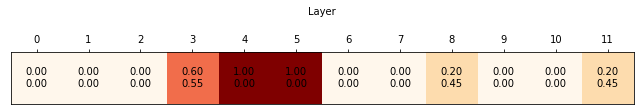

mean_survival_mean 0.25000000000000006
mean_survival_std 0.12017914570875686
stable mlps 2
QNLI
mask: [0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
[10  3  1]
flat [0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0.]
mask: [0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1.]
[6 5 4]
flat [0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0.]
mask: [0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0.]
[5 8 9]
flat [0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0.]
mask: [1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.]
[7 8 0]
flat [1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.]
mask: [1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1.]
[11  7  0]
flat [1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.]


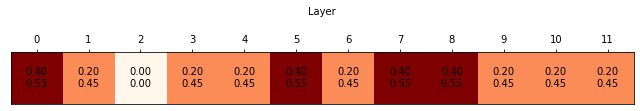

mean_survival_mean 0.25000000000000006
mean_survival_std 0.44344878321003095
stable mlps 0
QQP
mask: [0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.]
[ 7 10  4]
flat [0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.]
mask: [0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0.]
[ 9  5 10]
flat [0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0.]
mask: [1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1.]
[4 5 3]
flat [0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
mask: [1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1.]
[6 4 1]
flat [0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0.]
mask: [0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0.]
[ 6 10  9]
flat [0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0.]


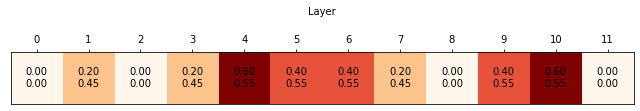

mean_survival_mean 0.25
mean_survival_std 0.3400211311688088
stable mlps 0
RTE
mask: [1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0.]
[4 3 0]
flat [1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
mask: [1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.]
[0 3 1]
flat [1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
mask: [1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1.]
[11  4  2]
flat [0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1.]
mask: [1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.]
[ 8  4 11]
flat [0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1.]
mask: [1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1.]
[7 8 3]
flat [0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0.]


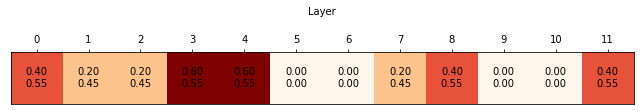

mean_survival_mean 0.25
mean_survival_std 0.3400211311688088
stable mlps 0
SST-2
mask: [0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
[ 9 11  2]
flat [0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1.]
mask: [0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1.]
[4 3 8]
flat [0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0.]
mask: [0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0.]
[ 8 10  2]
flat [0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0.]
mask: [1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0.]
[5 7 8]
flat [0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0.]
mask: [0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0.]
[6 1 8]
flat [0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.]


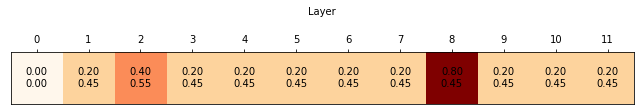

mean_survival_mean 0.25000000000000006
mean_survival_std 0.41832154270872884
stable mlps 0
STS-B
mask: [0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0.]
[7 2 3]
flat [0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0.]
mask: [1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1.]
[5 4 2]
flat [0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0.]
mask: [0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1.]
[7 2 6]
flat [0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0.]
mask: [0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0.]
[4 5 2]
flat [0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0.]
mask: [1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1.]
[5 3 4]
flat [0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0.]


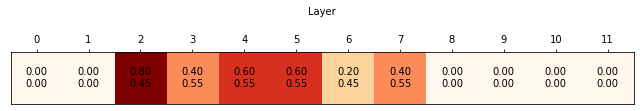

mean_survival_mean 0.25
mean_survival_std 0.2571097850850484
stable mlps 0
WNLI
mask: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 1  4 11]
flat [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
mask: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 1  4 11]
flat [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
mask: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 1  4 11]
flat [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
mask: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 1  4 11]
flat [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
mask: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 1  4 11]
flat [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


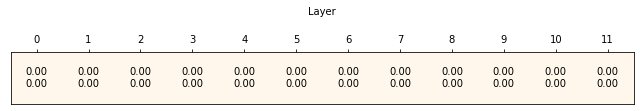

mean_survival_mean 0.0
mean_survival_std 0.0
stable mlps 0


In [115]:
show_task_specific_mlp_heatmap(together_mlp_data, None, None)